In [1]:
%reset -f
%matplotlib inline
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np

from aux import Generic
from ntwk import LIFNtwk
from disp import print_red, raster, set_font_size

import PARAMS as P_GLOBAL

# PARAMETERS AND CROSS-SIMULATION SUBROUTINES
<a id="params"></a>

[Jump to simulations](#simulations)

## Parameters

In [58]:
P = Generic(
    N=500,
    
    T_M=P_GLOBAL.T_M_PC,
    E_L=P_GLOBAL.E_L_PC,
    V_TH=P_GLOBAL.V_TH_PC,
    V_RESET=P_GLOBAL.V_RESET_PC,
    
    T_R=0.002,
    
    E_A=P_GLOBAL.E_A,
    E_N=P_GLOBAL.E_N,
    T_A=P_GLOBAL.T_A,
    T_N=P_GLOBAL.T_N,
    
    W_A_OUT_OUT=0.001,
    W_A_OUT_IN=P_GLOBAL.W_A_PC_PL,
    W_N_OUT_CTL_I=P_GLOBAL.W_N_PC_EC_I,
    W_N_OUT_CTL_F=P_GLOBAL.W_N_PC_EC_F,
    
    T_W=P_GLOBAL.T_W,
    T_C=P_GLOBAL.T_C,
    C_S=P_GLOBAL.C_S,
    B_C=P_GLOBAL.B_C,
    
    DT=P_GLOBAL.DT,
    
    T_END=8,
    
    T_STORE_0=1,
    T_STORE_1=3,
    
    FR_STORE=250,
    
    T_RECALL_0=5,
    T_RECALL_1=7,
    
    FR_RECALL=70,
    
    NOISE_STD=0.002,
    
    P_0=0.05,
    Q=0.2,
    
    T_FR_MA=0.05,
)

## Network structure

### Item assignment

In [3]:
def assign_items(n, q, q_star, test=False):
    """
    Probabilistically assign item labels to n neurons.
    Exactly 4 items are considered, with hard-coded 
    combination probabilities. Generalization to N items
    is beyond the scope of this project.
    
    :param n: number of neurons
    :param q: prob. of neuron being in any given item group
    :param q_star: prob. of neuron being in any specific second
        item group, given that it is in another first item group
        
    :return: n x 4 boolean array of item assignments
    """
    
    # specify all item combinations
    item_combos = [
        [],  # row 0
        [0,], [1,], [2,], [3,],  # row 1
        [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3],  # row 2
        [0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3],  # row 3
        [0, 1, 2, 3],  # row 4
    ]
    
    # compute probability of each combination
    
    ## p of row 1
    a = q * ((1 - q_star)**3)
    ## p of row 2
    b = q * q_star * ((1 - q_star)**2)
    ## p of row 3
    c = q * (q_star**2) * (1 - q_star)
    ## p of row 4
    d = q * (q_star**3)
    
    ## validate probabilities
    assert 4*a + 6*b + 4*c + d < 1
    
    ## full vector
    p = [
        1 - (4*a + 6*b + 4*c + d),  # row 0
        a, a, a, a,  # row 1
        b, b, b, b, b, b,  # row 2
        c, c, c, c,  # row 3
        d,  # row 4
    ]
    
    # assign labels
    labels = np.zeros((n, 4), bool)
    
    for i in range(n):
        
        # sample item assignment for i-th neuron
        item_combo = np.random.choice(item_combos, p=p)
        
        # convert to boolean
        labels[i, item_combo] = True
    
    if not test:
        
        return labels
    
    else:
        
        # estimate q
        q_hat = labels.mean()
        
        # estimate q_star
        q_star_hat = np.array([
            labels[labels[:, i], :][:, j].mean()
            for i, j in permutations(range(4), 2)
        ])
        
        return Generic(
            labels=labels, q_hat=q_hat, q_star_hat=q_star_hat)

#### Test

In [4]:
def test_assign_items_no_overlap():
    print_red('\n>> test_assign_items_no_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0.0
    
    rslt = assign_items(n=n, q=q, q_star=q_star, test=True)
    
    # ensure correct item probability  
    print_red('    q = {}'.format(q))
    print_red('    q_hat = {0:.4f}\n'.format(rslt.q_hat))

    # ensure no overlap
    print_red('    q* = {}'.format(q_star))
    print_red('    q*_hat = {0:.4f}\n'.format(rslt.q_star_hat.mean()))
    
    # ensure only 0 or 1 item per neuron
    print_red('    unique items per neuron ([0, 1]) = {}\n'.format(set(rslt.labels.sum(1))))
    

def test_assign_items_complete_overlap():
    print_red('\n>> test_assign_items_complete_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 1.0
    
    rslt = assign_items(n=n, q=q, q_star=q_star, test=True)
    
    # ensure correct item probability  
    print_red('    q = {}'.format(q))
    print_red('    q_hat = {0:.4f}\n'.format(rslt.q_hat))

    # ensure complete overlap
    print_red('    q* = {}'.format(q_star))
    print_red('    q*_hat = {0:.4f}\n'.format(rslt.q_star_hat.mean()))
    
    # ensure only 0 or 4 items per neuron
    print_red('    unique items per neuron ([0, 4]) = {}\n'.format(set(rslt.labels.sum(1))))
    

def test_assign_items_partial_overlap():
    print_red('\n>> test_assign_items_partial_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0.5
    
    rslt = assign_items(n=n, q=q, q_star=q_star, test=True)
    
    # ensure correct item probability  
    print_red('    q = {}'.format(q))
    print_red('    q_hat = {0:.4f}\n'.format(rslt.q_hat))

    # ensure correct partial overlap
    print_red('    q* = {}'.format(q_star))
    print_red('    q*_hat = {0:.4f}\n'.format(rslt.q_star_hat.mean()))
    
    # ensure any number of items per neuron
    print_red('    unique items per neuron ([0, 1, 2, 3, 4]) = {}\n'.format(set(rslt.labels.sum(1))))
            

np.random.seed(0)

test_assign_items_no_overlap()
test_assign_items_complete_overlap()
test_assign_items_partial_overlap()


>> TEST_ASSIGN_ITEMS_NO_OVERLAP...

    q = 0.2
    q_hat = 0.1985

    q* = 0.0
    q*_hat = 0.0000

    unique items per neuron ([0, 1]) = {0, 1}


>> TEST_ASSIGN_ITEMS_COMPLETE_OVERLAP...

    q = 0.2
    q_hat = 0.2014

    q* = 1.0
    q*_hat = 1.0000

    unique items per neuron ([0, 4]) = {0, 4}


>> TEST_ASSIGN_ITEMS_PARTIAL_OVERLAP...

    q = 0.2
    q_hat = 0.2005

    q* = 0.5
    q*_hat = 0.5047

    unique items per neuron ([0, 1, 2, 3, 4]) = {0, 1, 2, 3, 4}



Tests passed if:
1. Estimates (q_hat, q_star_hat) are near truth values.
1. If unique items per neuron match parentheticals.

### Recurrent weight matrix

In [5]:
def make_w_rcr_a(labels, p_0, p_1, P, test=False):
    """Create recurrent AMPA weight matrix given neuron labeling."""
    
    n = len(labels)
    
    # get all intra-item cxn possibilities
    mask_intras = []
    
    for i in range(4):
        
        # get intra-cxns for item i
        mask_intra_ = np.outer(labels[:, i], labels[:, i])
        
        # zero self-cxns
        np.fill_diagonal(mask_intra_, 0)
        
        mask_intras.append(mask_intra_)
    
    # take union of intra-item cxn possibilities
    mask_intra = np.logical_or.reduce(mask_intras)
    n_intra = mask_intra.sum()
    
    # build cxn matrix
    cxn = np.zeros((n, n), bool)
    
    # set intra-item cnxs
    assert 0 <= p_1 <= 1
    cxn[mask_intra] = np.random.binomial(1, p_1, n_intra)
    
    # set non-intra cxns
    p_2 = ((n * (n - 1) * p_0) - (n_intra * p_1)) / ((n * (n - 1)) - n_intra)
    
    assert 0 <= p_2 <= 1
    cxn[~mask_intra] = np.random.binomial(1, p_2, (~mask_intra).sum())
    
    # zero self-cxns
    np.fill_diagonal(cxn, 0)
    
    # convert to weight matrix
    w = cxn * P.W_A_OUT_OUT
    
    if not test:
        
        return w
    
    else:
        
        # estimate p_0
        mask_non_self = ~np.eye(n, dtype=bool)
        p_0_hat = (w > 0)[mask_non_self].mean()
        
        # estimate p_1
        p_1_hat = np.array([(w > 0)[mask_intra].mean() for mask_intra in mask_intras])
        
        return Generic(w=w, p_0_hat=p_0_hat, p_1_hat=p_1_hat)

#### Test

In [6]:
def test_make_w_rcr_a_no_overlap(P):
    print_red('\n>> test_make_w_rcr_a_no_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0
    
    p_0 = 0.1
    p_1s = [0, 0.1, 0.2]
    
    labels = assign_items(n=n, q=q, q_star=q_star)
    
    for p_1 in p_1s:
        
        rslt = make_w_rcr_a(labels, p_0, p_1, P, test=True)
        
        print_red('    p_0 = {}'.format(p_0))
        print_red('    p_0_hat = {0:.4f}\n'.format(rslt.p_0_hat))
        
        print_red('    p_1 = {}'.format(p_1))
        print_red('    p_1_hat = {0:.4f}\n'.format(rslt.p_1_hat.mean()))
        

def test_make_w_rcr_a_partial_overlap(P):
    print_red('\n>> test_make_w_rcr_a_partial_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0.5
    
    p_0 = 0.1
    p_1s = [0, 0.1, 0.2]
    
    labels = assign_items(n=n, q=q, q_star=q_star)
    
    for p_1 in p_1s:
        
        rslt = make_w_rcr_a(labels, p_0, p_1, P, test=True)
        
        print_red('    p_0 = {}'.format(p_0))
        print_red('    p_0_hat = {0:.4f}\n'.format(rslt.p_0_hat))
        
        print_red('    p_1 = {}'.format(p_1))
        print_red('    p_1_hat = {0:.4f}\n'.format(rslt.p_1_hat.mean()))
        

test_make_w_rcr_a_no_overlap(P)
test_make_w_rcr_a_partial_overlap(P)


>> TEST_MAKE_W_RCR_A_NO_OVERLAP...

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0
    p_1_hat = 0.0000

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.1
    p_1_hat = 0.0999

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.2
    p_1_hat = 0.2000


>> TEST_MAKE_W_RCR_A_PARTIAL_OVERLAP...

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0
    p_1_hat = 0.0000

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.1
    p_1_hat = 0.0999

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.2
    p_1_hat = 0.1999



Tests passed if:
1. All estimates (*_hat) approximate truth values.

### Upstream AMPA weights (from item inputs)

In [7]:
def make_w_up_a(labels, P):
    
    n = len(labels)
    
    # IN (item inputs)
    cxns_up_a_item = []
    
    # loop over items
    for label in labels.T:
        # make one input unit per output unit in this item
        cxn_up_a_item = np.zeros((n, label.sum()), bool)
        
        for j, idx in enumerate(label.nonzero()[0]):
            cxn_up_a_item[idx, j] = True
            
        cxns_up_a_item.append(cxn_up_a_item)
        
    w_up_a_item = np.concatenate(cxns_up_a_item, 1) * P.W_A_OUT_IN
    
    # CTL (control channels)
    w_up_a_ctl = np.zeros((n, n))
    
    w_up_a = np.concatenate([w_up_a_item, w_up_a_ctl], 1)
    
    return w_up_a

#### Test

In [8]:
def test_make_w_up_a():
    
    labels = np.array([
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
    ]).T
    
    w_up_a = make_w_up_a(labels, Generic(W_A_OUT_IN=2.))
    
    assert w_up_a.shape == (len(labels), 2 + 4 + 5 + len(labels))
    
    w_up_a_item = w_up_a[:, :(2 + 4 + 5)]
    
    w_up_a_item_correct = 2. * np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    ]).T
    
    np.testing.assert_array_equal(w_up_a_item, w_up_a_item_correct)

    assert np.all(w_up_a[:, (2 + 4 + 5):] == 0)
    
    print_red('All tests passed.')
    
test_make_w_up_a()

All tests passed.


### Upstream NMDA weights (from control inputs)

In [9]:
def make_w_up_n(labels, P):
    
    n = len(labels)
    
    # IN (item inputs)
    w_up_n_in = np.zeros((n, labels.sum()))
    
    # CTL (control channels)
    w_up_n_ctl = np.eye(n) * P.W_N_OUT_CTL_I
    
    w_up_n = np.concatenate([w_up_n_in, w_up_n_ctl], 1)
    
    return w_up_n

### Top-level build

In [10]:
def make_ntwk(n, q, q_star, p_0, p_1, P):
    """Create LIFNtwk with plastic CTL->OUT synapses."""

    # assign items to nrns and sort into balanced groups
    labels = [[] for _ in range(5)]
    
    for label in assign_items(n, q, q_star):
        
        items = label.nonzero()[0]
        
        if not items.size:
            group = 0
        else:
            group = np.random.choice(items) + 1
        
        labels[group].append(label)
    
    labels = [np.array(labels_) for labels_ in labels]
    labels = np.concatenate(labels, 0)
    
    # get recurrent w
    w_rcr_a = make_w_rcr_a(labels, p_0, p_1, P)
    w_rcr_n = np.zeros((n, n))
    
    ws_rcr = {'AMPA': w_rcr_a, 'NMDA': w_rcr_n}
    
    # get upstream w
    w_up_a = make_w_up_a(labels, P)
    w_up_n = make_w_up_n(labels, P)
    
    ws_up = {'AMPA': w_up_a, 'NMDA': w_up_n}
    
    # make plasticity masks
    masks_plastic = {
        'AMPA': np.zeros((n, labels.sum() + n), bool),
        'NMDA': np.concatenate([np.zeros((n, labels.sum()), bool), np.eye(n, dtype=bool)], 1)
    }
    
    # set synaptic params
    es_syn = {'AMPA': P.E_A, 'NMDA': P.E_N}
    ts_syn = {'AMPA': P.T_A, 'NMDA': P.T_N}
    
    # set plasticity params
    plasticity = {
        'masks': masks_plastic,
        'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_OUT_CTL_F},
        'T_W': P.T_W,
        'T_C': P.T_C,
        'C_S': P.C_S,
        'BETA_C': P.B_C,
    }
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.T_M, n),
        e_l=np.repeat(P.E_L, n),
        v_th=np.repeat(P.V_TH, n),
        v_reset=np.repeat(P.V_RESET, n),
        t_r=np.repeat(P.T_R, n),
        es_syn=es_syn,
        ts_syn=ts_syn,
        ws_rcr=ws_rcr,
        ws_up=ws_up,
        plasticity=plasticity)
    
    ntwk.labels = labels
    
    return ntwk

## Stimulation paradigm

### Upstream spks with item info

In [11]:
def make_spks_up(ntwk, items, P):
    """Create an input spike train to imprint and recall items."""
    
    t = np.arange(0, P.T_END, P.DT)
    
    spks_up = np.zeros((len(t), ntwk.labels.sum() + ntwk.n))
    
    # storage
    t_mask_store = (P.T_STORE_0 <= t) & (t < P.T_STORE_1)

    starts_ends = [0] + list(ntwk.labels.sum(0).cumsum())
    
    for i in items:
        start = starts_ends[i]
        end = starts_ends[i+1]
        
        spks_up[t_mask_store, start:end] = \
            np.random.poisson(P.DT * P.FR_STORE, size=(t_mask_store.sum(), end-start))
            
    # recall
    mask_recall = (P.T_RECALL_0 <= t) & (t < P.T_RECALL_1)
    spks_up[mask_recall, ntwk.labels.sum():] = \
        np.random.poisson(P.DT * P.FR_RECALL, size=(mask_recall.sum(), ntwk.n))
    
    return spks_up

#### Test

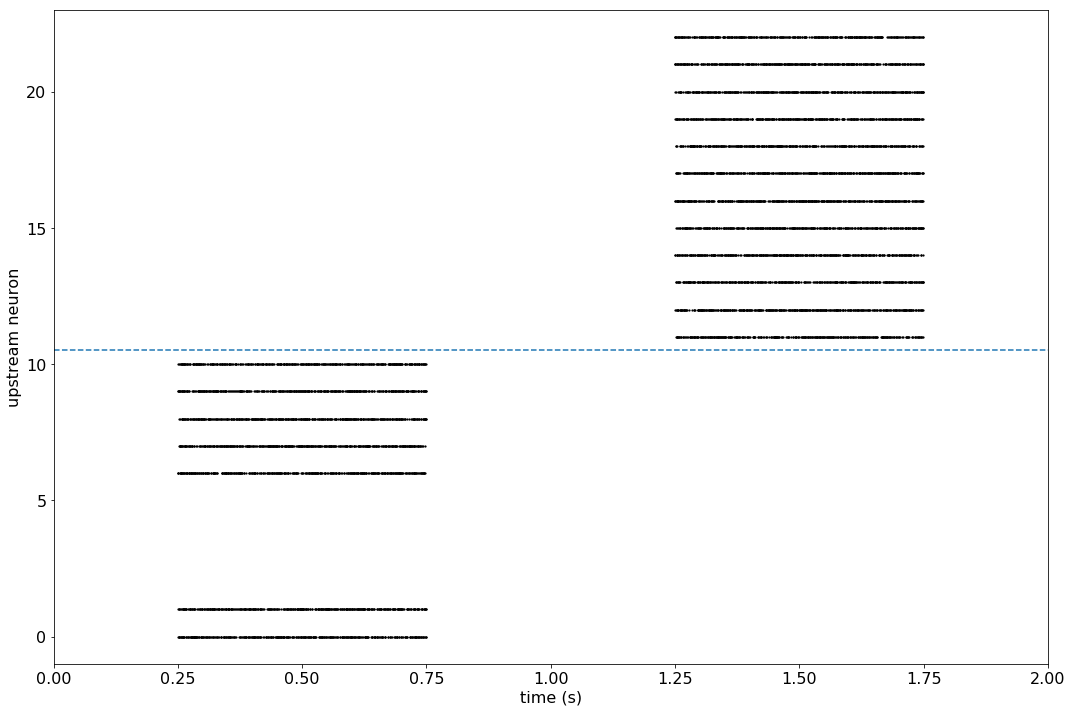

In [12]:
def test_make_spks_up(P):
    
    labels = np.array([
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
    ]).T
    
    p = Generic(
        T_END=2,
        DT=P.DT,
        T_STORE_0=0.25,
        T_STORE_1=0.75,
        FR_STORE=0.5/P.DT,
        T_RECALL_0=1.25,
        T_RECALL_1=1.75,
        FR_RECALL=0.5/P.DT)
    
    ntwk = Generic(n=len(labels), labels=labels)
    spks_up = make_spks_up(ntwk, [0, 2], p)
    
    assert spks_up.shape[1] == (labels.sum() + ntwk.n)
    
    spk_times, spk_idxs = spks_up.nonzero()
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), tight_layout=True)
    
    ax.scatter(P.DT * spk_times, spk_idxs, s=5, lw=0, c='k')
    ax.axhline(10.5, ls='--')
    
    ax.set_xlim(0, 2)
    ax.set_ylim(-1, spks_up.shape[1])
    
    ax.set_xlabel('time (s)')
    ax.set_ylabel('upstream neuron')
    
    set_font_size(ax, 16)
    
test_make_spks_up(P)

Test passed if rows 0 - 1 and 6 - 10 (inclusive) are active from 0.25 to 0.75 s, and rows 11 - 22 are active from 1.25 to 1.75 s.

### White noise

In [13]:
def make_noise(ntwk, P):
    """Create a white noise process to add to the output neurons."""
    
    t = np.arange(0, P.T_END, P.DT)
    
    noise = np.random.normal(0, P.NOISE_STD, (len(t), ntwk.n))
    
    return t, noise

#### Test

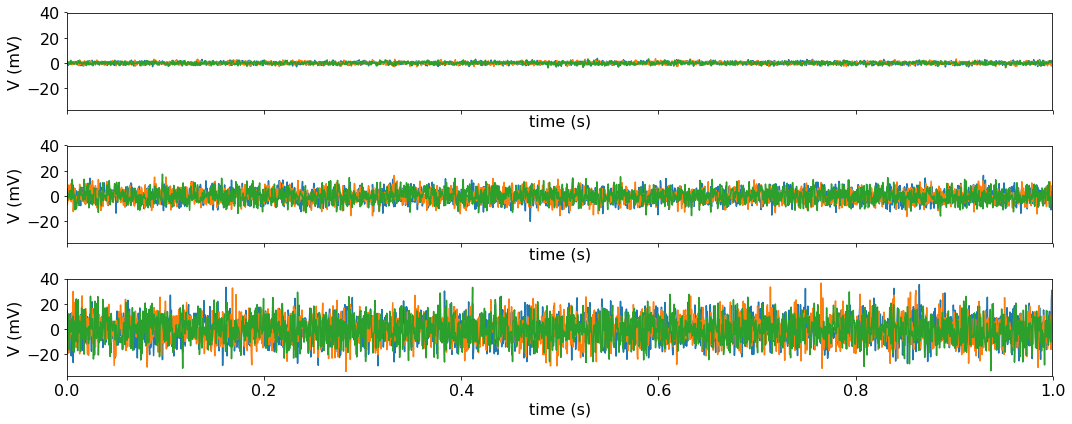

In [14]:
def test_make_noise(noise_stds, P):
    
    ntwk = Generic(n=3)
    
    n_axs = len(noise_stds)
    fig_size = (15, n_axs*2)
    
    fig, axs = plt.subplots(n_axs, 1, figsize=fig_size, sharex=True, sharey=True, squeeze=False, tight_layout=True)
    
    for noise_std, ax in zip(noise_stds, axs[:, 0]):
        
        p = Generic(
            DT=P.DT,
            T_END=1,
            NOISE_STD=noise_std
        )
        
        t, noise = make_noise(ntwk, p)
        
        ax.plot(t, 1000 * noise)
        
        ax.set_xlim(0, t[-1])
        
        
    for ax in axs[:, 0]:
        
        ax.set_xlabel('time (s)')
        ax.set_ylabel('V (mV)')
        set_font_size(ax, 16)
        
test_make_noise([0.001, 0.005, 0.01], P)

## Recall accuracy

In [15]:
def calc_acc(rsp, items, P):
    acc = 3.14159
    return acc

# SIMULATIONS

## Examples

### Simulation code

In [16]:
def xmpl(q_star, p_0, p_1, items, P):
    """
    Run example simulation and output a raster plot,
    population firing rate plot, and plot of synaptic weight
    changes over time."""

    # build ntwk and run smln
    ntwk = make_ntwk(n=P.N, q=P.Q, q_star=q_star, p_0=p_0, p_1=p_1, P=P)
    spks_up = make_spks_up(ntwk, items, P)
    noise = make_noise(ntwk, P)[1]
    
    rsp = ntwk.run(spks_up=spks_up, dt=P.DT, i_ext=noise, report_every=10)
    rsp.labels = ntwk.labels
    acc = calc_acc(rsp, items, P)
    
    # population firing rates
    ## take moving average
    
    n_t_ma = int(P.T_FR_MA / P.DT)
    
    ### indiv items
    frs_ma = []
    
    for i in range(4):

        spk_ct_i = rsp.spks[:, ntwk.labels[:, i]].mean(1)
        spk_ct_i_ma = np.convolve(spk_ct_i, np.ones(n_t_ma), mode='same')
        fr_ma = spk_ct_i_ma / P.T_FR_MA
        
        frs_ma.append(fr_ma)
            
    ### whole pop
    spk_ct_pop = rsp.spks.mean(1)
    spk_ct_pop_ma = np.convolve(spk_ct_pop, np.ones(n_t_ma), mode='same')
    fr_pop_ma = spk_ct_pop_ma / P.T_FR_MA
        
    # show raster and CTL->OUT weights
    fig, axs = plt.subplots(3, 1, figsize=(15, 12), tight_layout=True)

    ## raster
    raster(axs[0], rsp.ts, rsp.spks, lw=1, s=5)
    
    axs[0].set_ylim(0, ntwk.n)
    
    # plot moving averages
    colors_item = ['k', 'b', 'g', 'r']
    color_pop = 'gray'
    
    for fr_ma, color in zip(frs_ma, colors_item):
        axs[1].plot(rsp.ts, fr_ma, lw=3, color=color)

    axs[1].plot(rsp.ts, fr_pop_ma, lw=3, color=color_pop)
    
    axs[1].set_xlabel('time (s)')
    axs[1].set_ylabel('firing rate (Hz)')
    
    axs[1].legend(['Item 1', 'Item 2', 'Item 3', 'Item 4', 'Ntwk'])
        
    ## CTL->OUT weights
    #w_out_ctl_items = ...
    #w_out_ctl_all = ...

    #axs[1].plot(rsp.ts, w_out_ctl_all, color='k', lw=2)
    #axs[1].plot(rsp.ts, w_out_ctl_items, color='r', lw=2)
    
    axs[0].set_title('ACC = {0:.4f}'.format(acc))
    
    for ax in axs:
        set_font_size(ax, 16)
        
    return Generic(
        ntwk=ntwk,
        items=items,
        spks_up=spks_up,
        rsp=rsp,
        acc=acc,
        fig=fig,
        ax=axs)

<a id="simulations"></a>
[Jump to parameters](#params)
### Single-item, overlap, equal inter/intra recurrence

1512/16000 steps completed after 10.006 s...
3028/16000 steps completed after 20.007 s...
4544/16000 steps completed after 30.008 s...
6059/16000 steps completed after 40.009 s...
7562/16000 steps completed after 50.010 s...
9075/16000 steps completed after 60.013 s...
10590/16000 steps completed after 70.019 s...
12106/16000 steps completed after 80.020 s...
13622/16000 steps completed after 90.021 s...
15137/16000 steps completed after 100.027 s...


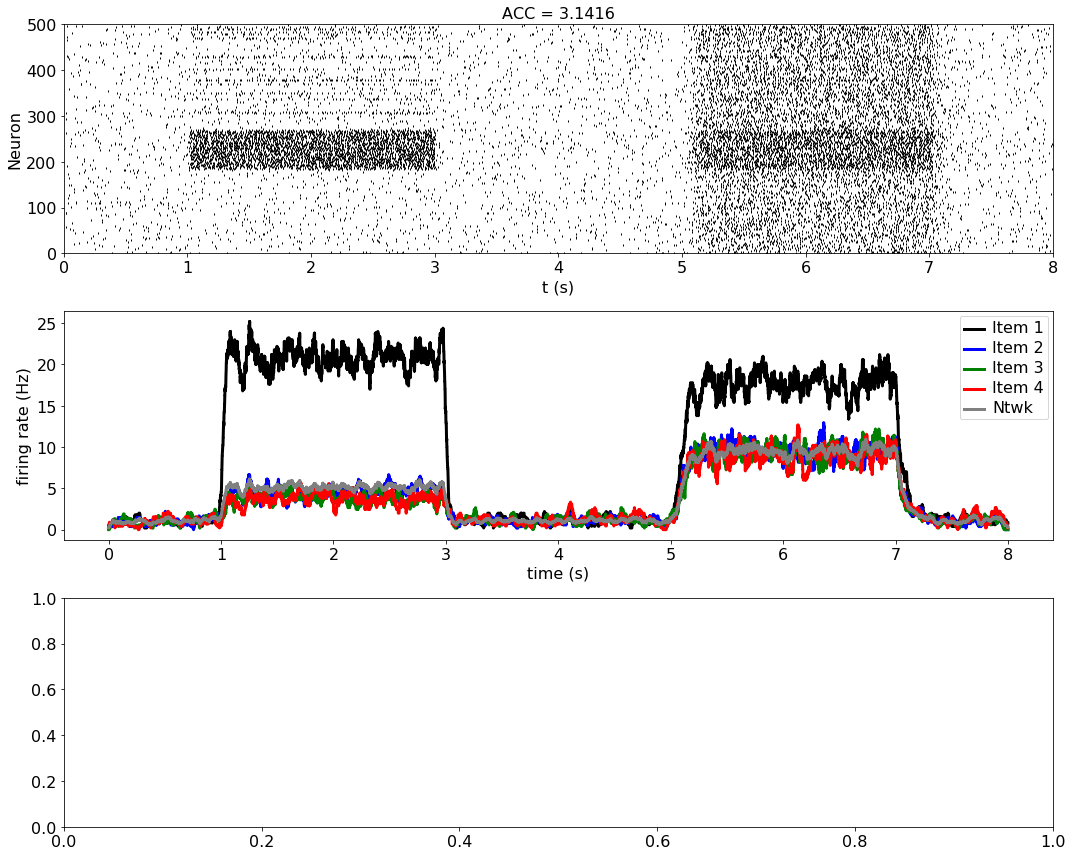

In [59]:
np.random.seed(0)
xmpl(q_star=0.15, p_0=P.P_0, p_1=0.2, items=[0], P=P)

## Parameter dependence

### Simulation

In [ ]:
def param_variation(q_stars, p_0s, p_1s):
    
    return Generic(
        ...
    )